In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('fpl_final.csv', )
print(f'The data contains {df.shape[0]} rows and {df.shape[1]} of features \n')

df.head(3)


The data contains 770 rows and 12 of features 



,Elements Clean Sheets Per 90,Elements Saves,Elements Transfers In Event,Elements Form Rank,Elements Transfers Out Event,Elements Assists,Elements Expected Goals Conceded Per 90,Elements Saves Per 90,Elements Goals Conceded Per 90,Elements Expected Assists Per 90,Elements Yellow Cards,Elements Event Points
0,0.0845,2.0,11.0,731.55,5.0,1.0,0.82,1.88,0.7445,0.01,1.0,1.0
1,0.3000,2.0,67.0,731.55,5730.0,2.0,0.87,1.88,0.7500,0.08,4.0,1.0
2,0.3300,2.0,23890.4,136.00,14317.0,2.0,0.93,1.88,0.9500,0.05,3.0,2.0


In [3]:
df['Elements Event Points'].value_counts()

Elements Event Points
1.00     338
2.00     183
6.00      51
3.00      43
10.55     39
5.00      25
10.00     22
8.00      22
7.00      19
4.00      16
9.00      12
Name: count, dtype: int64

The target col already has quite a significant imbalance which would impact the binning technique. A potential work around is to use StratifiedKFold. This should generate test sets where the distribution is similar across, or as close as possible.

In [4]:
df.rename(columns={'Elements Clean Sheets Per 90': 'clean_sheets_per_90', 
                   'Elements Saves': 'saves',
                   'Elements Transfers In Event': 'transfers_in',
                   'Elements Form Rank':'form_rank',
                   'Elements Transfers Out Event': 'transfers_out',
                   'Elements Assists': 'assists',
                   'Elements Expected Goals Conceded Per 90': 'xgc_per_90',
                   'Elements Saves Per 90': 'saves_per_90',
                   'Elements Goals Conceded Per 90': 'gc_per_90',
                   'Elements Expected Assists Per 90':'xa_per_90',
                   'Elements Yellow Cards': 'yellow_cards',
                   'Elements Event Points': 'player_raw_fplscore'

                   }, inplace=True)

df.columns

Index(['clean_sheets_per_90', 'saves', 'transfers_in', 'form_rank',
       'transfers_out', 'assists', 'xgc_per_90', 'saves_per_90', 'gc_per_90',
       'xa_per_90', 'yellow_cards', 'player_raw_fplscore'],
      dtype='object')

In [5]:
#Split into predictors and target
X= df[[col for col in df.columns if col != 'player_raw_fplscore']]

y = df['player_raw_fplscore']

In [6]:
#to ensure equal distribution across train and test, bin target values

# Create 5 bins based on quantiles
#y_binned = pd.qcut(y, q=5, labels=False, duplicates= 'drop')  # Creates 5 equal-sized bins

# Check bin distribution
#print(y_binned.value_counts())

In [7]:
#to ensure equal distribution across train and test, bin target values
#from sklearn.model_selection import StratifiedKFold

#skf = StratifiedKFold(shuffle=True, random_state=42) #initiliaze stratifiedkfold
#skf.get_n_splits(X, y_binned)
#print(skf)

In [8]:
#split data into 75 25 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify= y, random_state=42)

# Split the data using StratifiedKFold on the binned target
#for train_idx, test_idx in skf.split(X, y_binned):
#    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [9]:
# Binning features to ensure balanced representation of the target variable across both train and test sets

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [11]:
#Standardization of train value
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
#RandomizedSearchCV for Hyperparameter Tuning
rf = RandomForestRegressor(random_state=42)

# Define hyperparameter space for RandomizedSearchCV
param_dist = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 8],
              'min_samples_leaf': [1, 2, 4]}


# RandomizedSearchCV with Cross-Validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit model
random_search.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

# Model Evaluation
final_score = best_model.score(X_test_scaled, y_test)
print(f"Test Set R2 Score: {final_score}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Test Set R2 Score: 0.5047400935131632


In [18]:
#!pip install xgboost

In [27]:
# try with xgboost
import xgboost as xgb

#XGBoost Model and Hyperparameter Tuning
xg_reg = xgb.XGBRegressor(random_state=42)

# Hyperparameter grid for RandomizedSearchCV
param_dist_xg = {'n_estimators': [50, 100,150, 200],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [3, 6, 9,12],
              'min_child_weight': [1, 5, 10],
              'subsample': [0.8, 1.0],
              'colsample_bytree': [0.8, 1.0]
              }

# RandomizedSearchCV with Cross-Validation
random_search_xg = RandomizedSearchCV(estimator=xg_reg, param_distributions=param_dist_xg,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search_xg.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_model_xg = random_search.best_estimator_
print("Best hyperparameters:", random_search_xg.best_params_)

final_score_xg = best_model_xg.score(X_test_scaled, y_test)
print(f"Test Set R2 Score: {final_score_xg}")

# 4. Model Evaluation
#y_pred = best_model.predict(X_test_scaled)
#mse = mean_squared_error(y_test, y_pred)
#print(f"Test Set Mean Squared Error: {mse}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'subsample': 0.8, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Test Set R2 Score: 0.508633086952663


In [28]:
from sklearn.linear_model import Ridge

#Ridge Regression Model and Hyperparameter Tuning
ridge_reg = Ridge(random_state=42)

# Hyperparameter grid for RandomizedSearchCV
param_dist_ridge = {'alpha': [1, 1.3, 1.6, 1.9, 2, 2.2, 2.5],
                    'solver': ['auto','svd','sag','cholesky']
                    }

# RandomizedSearchCV with Cross-Validation
random_search_ridge = RandomizedSearchCV(estimator=ridge_reg, param_distributions=param_dist_ridge,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search_ridge.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_model_ridge = random_search_ridge.best_estimator_
print("Best hyperparameters:", random_search_ridge.best_params_)

final_score_ridge = best_model_ridge.score(X_test_scaled, y_test)
print(f"Test Set R2 Score: {final_score_ridge}")

c:\Users\On3B3\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 28 is smaller than n_iter=100. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best hyperparameters: {'solver': 'auto', 'alpha': 2.5}
Test Set R2 Score: 0.15743824756639768


In [ ]:
from sklearn.svm import SVR

# Initialize GBR model
svr = SVR()

# Define hyperparameter grid
param_grid = {'C': [6, 8, 14, 16, 32],  # Regularization strength
              'epsilon': [ 1.3, 2.1, 2.4,2.7,3.0],  # Tolerance for error
              'kernel': ['linear', 'rbf', 'poly']  # Kernel type
              }


# RandomizedSearchCV with Cross-Validation
random_search_svr = RandomizedSearchCV(estimator=svr, param_distributions=param_grid,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search_svr.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_model_svr = random_search_svr.best_estimator_
print("Best hyperparameters:", random_search_svr.best_params_)

final_score_svr = best_model_svr.score(X_test_scaled, y_test)
print(f"Test Set R2 Score: {final_score_svr}")

c:\Users\On3B3\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best hyperparameters: {'kernel': 'rbf', 'epsilon': 1.3, 'C': 8}
Test Set R2 Score: 0.3113873771157387


In [56]:
# try with GBR
from sklearn.ensemble import GradientBoostingRegressor

#XGBoost Model and Hyperparameter Tuning
gbr = GradientBoostingRegressor(random_state= 42)

# Hyperparameter grid for RandomizedSearchCV
param_grid_gbr = {
    'n_estimators': [25,150, 200, 250],
    'learning_rate': [0.01,0.05, 0.1, 0.2,0.3,0.4,0.6,1],
    'max_depth': [2,3,4],
    'min_samples_split': [3,4,6],
    'min_samples_leaf': [ 3,4,6]
}

# RandomizedSearchCV with Cross-Validation
random_search_gbr = RandomizedSearchCV(estimator=gbr,param_distributions=param_grid_gbr,n_iter=50,scoring='r2',
                                       cv=5,verbose=2,random_state=42,n_jobs=-1
                                       )

# Fit the model
random_search_gbr.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_model_gbr = random_search_gbr.best_estimator_
print("Best hyperparameters:", random_search_gbr.best_params_)

final_score_gbr = best_model_gbr.score(X_test_scaled, y_test)
print(f"Test Set R2 Score: {final_score_gbr}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 4, 'learning_rate': 0.1}
Test Set R2 Score: 0.5016024203511575


From all the models experimented with XGBoost has the best R2 with 50.8%
will use this to build the model

In [58]:
#Train XGBoost model with best params
best_xgboost = xgb.XGBRegressor(**random_search_xg.best_params_, random_state=42)

# Fit the model
best_xgboost.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [59]:
from sklearn.metrics import r2_score, mean_squared_error

# Predictions
y_train_pred = best_xgboost.predict(X_train_scaled)
y_test_pred = best_xgboost.predict(X_test_scaled)

# R² Score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R² Score: {r2_train:.4f}")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

Train R² Score: 1.0000
Test R² Score: 0.4962
Train RMSE: 0.0005
Test RMSE: 2.0805


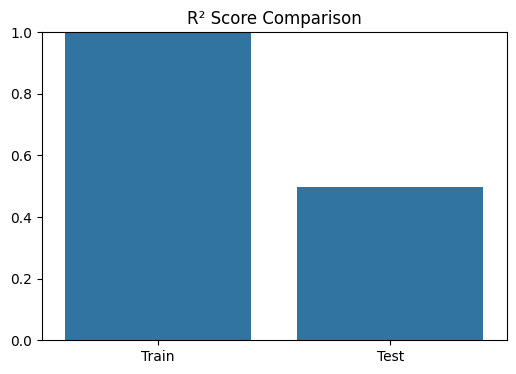

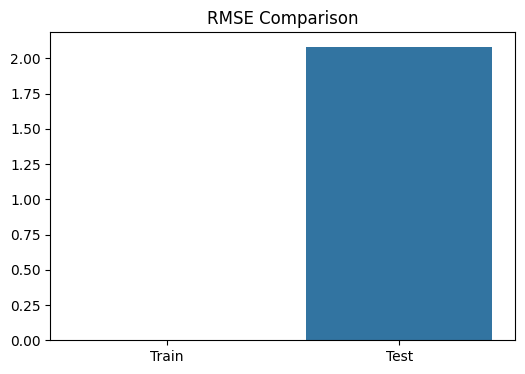

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot R² Scores
plt.figure(figsize=(6,4))
sns.barplot(x=['Train', 'Test'], y=[r2_train, r2_test])
plt.ylim(0, 1)
plt.title('R² Score Comparison')
plt.show()

# Plot RMSE
plt.figure(figsize=(6,4))
sns.barplot(x=['Train', 'Test'], y=[rmse_train, rmse_test])
plt.title('RMSE Comparison')
plt.show()

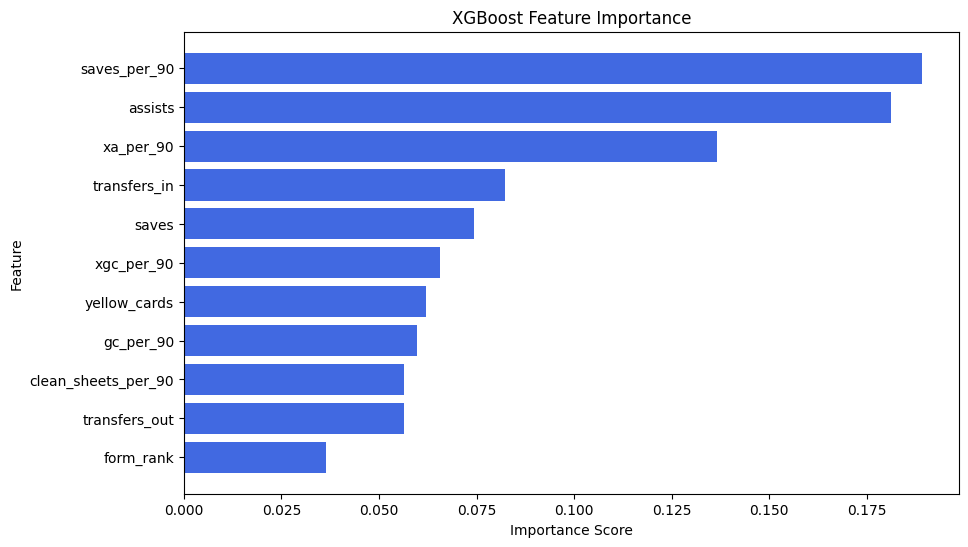

In [61]:
# Get feature importance
feature_importance = best_xgboost.feature_importances_

# Create a DataFrame
feat_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='royalblue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip to show most important on top
plt.show()

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 80.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -------------------- ------------------- 15.5/30.3 MB 69.4 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 74.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


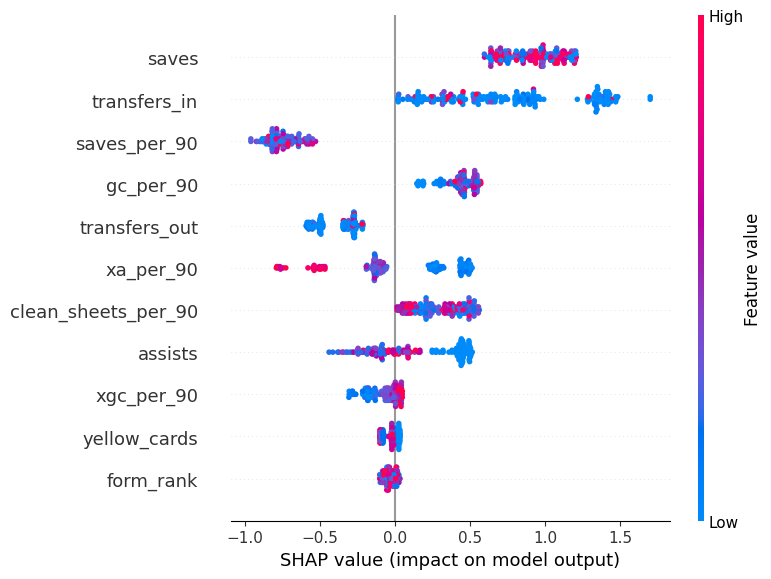

In [63]:
#!pip install shap
import shap

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(best_xgboost)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

based on the results it appears the model is overfitting
1. demonstrated by the high r2 on the train (1) and low on the test (0.49)

The model is also generalizing poorly. 
1.  This is shown by the high rmse value on test versus the low value on train.


Will need to revist the data wrangling and feature engineering steps  to try and reduce the complexity of the data and improve preprocessing steps.

In [64]:
#save model

import pickle

with open("xgboost_fpl_model.pkl", "wb") as file:
    pickle.dump(best_xgboost, file)